# FULL PIPELINE


This notebook will merge four steps:

1 -  segment electrodes from fluoroscopy return coordinates

2 - segment electodes from CT return coordinates

3 -  map CT to 2D

4 -  map coordinates back to 3D

For now, we will demonstrate the full pipeline on DBS_bT20 data sample

## READ ALL THE DATA

In [1]:
# Import dependencies
import nibabel as nib
import numpy as np
import cv2
import scipy.io
import os
import imageio

# Define file names
SAMPLE_NAME = "DBS_bT20"
HULL_FILE_NAME = os.path.join(SAMPLE_NAME,"hull_rh.mat")
PRECT_FILE_NAME = os.path.join(SAMPLE_NAME,"rpreop_ct.nii")
POSTCT_FILE_NAME = os.path.join(SAMPLE_NAME,"rpostop_ct.nii")
FLUORO_FILE_NAME = os.path.join(SAMPLE_NAME,"fluoro20.tif")

# read .mat File
hull = scipy.io.loadmat(HULL_FILE_NAME)
points_hull=np.array(hull['mask_indices'])

#read pre op CT
prect = nib.load(PRECT_FILE_NAME)
prect_data = np.nan_to_num(np.array(prect.get_fdata()))
Tmatrix = np.transpose(prect.affine)

#read post op CT
postct = nib.load(POSTCT_FILE_NAME)
postct_data = np.nan_to_num(np.array(postct.get_fdata()))

# fourth channel is infrared
fluoro = imageio.imread(FLUORO_FILE_NAME)
fluoro = cv2.cvtColor(fluoro, cv2.COLOR_BGR2GRAY)

## STEP 1: SEGMENT FROM FLUORO

In [2]:
# Run first component script
from fluoro_segmentation import fluoro_get_electrode_coordinates
coords_dict = fluoro_get_electrode_coordinates(fluoro)

fluoro_segmentation.py successfully executed.


### Visual Check

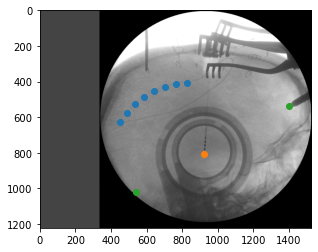

In [3]:
# Display segmented features on fluoro image
import matplotlib.pyplot as plt
plt.imshow(fluoro,cmap='gray')
plt.scatter(coords_dict['ecog'][:,0], coords_dict['ecog'][:,1])
plt.scatter(coords_dict['dbs'][0], coords_dict['dbs'][1])
plt.scatter(coords_dict['pin'][:,0], coords_dict['pin'][:,1])

## STEP 2: SEGMENT FROM CT

In [4]:
# Run second component script
from ct_segmentation import ct_get_landmarks
coords3d_dic = ct_get_landmarks(prect_data, postct_data)
pins_ct = coords3d_dic['pin']

ct_segmentation.py successfully executed.


### Visual Check

In [5]:
# Display the segmented features on CT volume
from mayavi import mlab
mlab.init_notebook()
fig = mlab.figure(bgcolor=(1, 1, 1), size=(500, 500))
source_1 = mlab.pipeline.scalar_field(prect_data)
surface = mlab.pipeline.iso_surface(source_1, 
                          contours=[256,], 
                          opacity=0.5, 
                          colormap = 'black-white')

source_2 = mlab.pipeline.scalar_field(postct_data[:,:128,:])
surface = mlab.pipeline.iso_surface(source_2, 
                          contours=[256,], 
                          opacity=0.8, 
                          colormap = 'black-white')
mlab.points3d(pins_ct[:,0],pins_ct[:,1],pins_ct[:,2], color = (0.2,1,.2), scale_factor=10)

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…

## STEP 3: MAP TO 2D

When converting from pixel to 3d coordinate mayavi just centers x and y, so (1400,1200) image will have a center at (700,600) and possibly x and y switched

In [6]:
# Refine inputs to 3rd component function

dbs = np.array([coords_dict['dbs']])
pins2d = coords_dict['pin']
pins_fl = np.concatenate((dbs,pins2d),axis=0)
coords_2d = coords_dict['ecog']


In [7]:
# Run third component function
from fluoro_ct_alignment import project_to_2d
aligned_coords = project_to_2d(postct_data,fluoro,pins_fl,pins_ct,coords_2d)

fluoro_ct_alignment.py successfully executed.


### Visual Inspect

In [8]:
# For now, display aligned coordinate values. In future, will display coordinates superimposed with fluoro and CT slice images
aligned_coords

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int64)

## STEP 4: MAP TO 3D

In [9]:
# Run fourth component function
from hull_projection import project_to_3d
predictions = project_to_3d(aligned_coords, points_hull, Tmatrix)
predictions = np.array(predictions)
predictions

hull_projection.py executed succesfully


array([[ 48, -73,  21],
       [ 45, -68,  28],
       [ 44, -62,  34],
       [ 44, -55,  40],
       [ 45, -47,  44],
       [ 42, -39,  47],
       [ 39, -31,  50],
       [ 43, -21,  51]])

### Visual Inspect

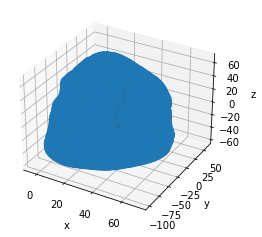

In [10]:
# Inspect the projected coordinates on the MRI hull
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(points_hull[:,0], points_hull[:,1], points_hull[:,2], cmap='green', alpha=0.2)
ax.scatter3D(predictions[:,0], predictions[:,1], predictions[:,2], c='r',)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

For a better visualization, use plotly or mayavi. Here for the sake of fast visualization we use matplotlib.

In [11]:
#Compare predicted coordinates with grouth truth coordinates
scipy.io.loadmat("DBS_bT20/Electrode_Locations_JWC/electrode_locs.mat")

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Aug 28 22:35:58 2020',
 '__version__': '1.0',
 '__globals__': [],
 'CortElecLoc': array([[array([[ 48.88512421, -73.83932495,  21.71887207]]),
         array([[ 45.88512421, -68.83932495,  28.71887207]]),
         array([[ 44.88512421, -62.83932495,  34.71887207]]),
         array([[ 44.88512421, -55.83932495,  40.71887207]]),
         array([[ 45.88512421, -47.83932495,  44.71887207]]),
         array([[ 42.88512421, -39.83932495,  47.71887207]]),
         array([[ 39.88512421, -31.83932495,  50.71887207]]),
         array([[ 43.88512421, -21.83932495,  51.71887207]])]],
       dtype=object)}